# Plot histograms from a single ICON-ModEx iteration

Taking a close look at the following three histograms is often a good way to assess the potential biases in an ML model:
+ distribution of the observed (i.e. target) data
+ distribution of the predictions based on the training data
+ distribution of the predictions on testing data (i.e. data points never included in training, many of which we don't know what the values are -> they are extrapolated)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

#======================
# Parameters
#======================

# Number of histogram bins and ranges (log10)
nbin = 30
min_bin = -1.0
max_bin = 4.0

# Where is the archive and where do we want to make a local copy of the archive?
repo_prefix = '~/tmp/'
repo_org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+repo_org+'/'+repo_name

# Which branch do we want to visualize?
#branch_name='Nov-2023-log10-DO-update-correct-v7.1-Action'
branch_name='no-hot-spots-in-training'
#branch_name='Nov-2023-log10'
#branch_name='Oct-2023-log10'

# Set all font sizes in the plots
font = {'family' : 'sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

## Load data

In [2]:
# Make a local copy of the archive
! mkdir -p {repo_prefix}
! cd {repo_prefix}; git clone {repo_url}

# Change to the requested branch
! cd {repo_prefix}/{repo_name}; git checkout {branch_name}

# Load data we want to prepare/merge/preprocess
data_prefix=repo_prefix+'/'+repo_name
observations = pd.read_csv(data_prefix+"/scripts/prep_01_output_train.csv")
predictions = pd.read_csv(data_prefix+'/scripts/post_01_output_ml_predict_avg.csv')

# Need to separate out the S19S, CM_, and SSS sites from the predictions all
# because we want to plot the histogram of training data predictions separately
# from the histogram of extrapolated data predictions.
predictions.set_index('Sample_ID', inplace=True)
observations.set_index('Sample_ID', inplace=True)

# Drop missing data
# SSS0005-* sites are missing lon/lat
# S19S_0085-* sites are missing oxygen
observations.drop(['SSS005-1', 'SSS005-2', 'SSS005-3', 'S19S_0085-D', 'S19S_0085-M', 'S19S_0085-U'], inplace=True)

# Get just the training predictions
training_predictions=predictions.loc[observations.index]

# Filter out the training predictions from the all predictions dataframe
# so the result here is only predictions at extrapolation sites.
predictions.drop(index=observations.index, inplace=True)

fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.
Updating files: 100% (390/390), done.
Switched to branch 'no-hot-spots-in-training'
Your branch is up to date with 'origin/no-hot-spots-in-training'.


## Make histograms

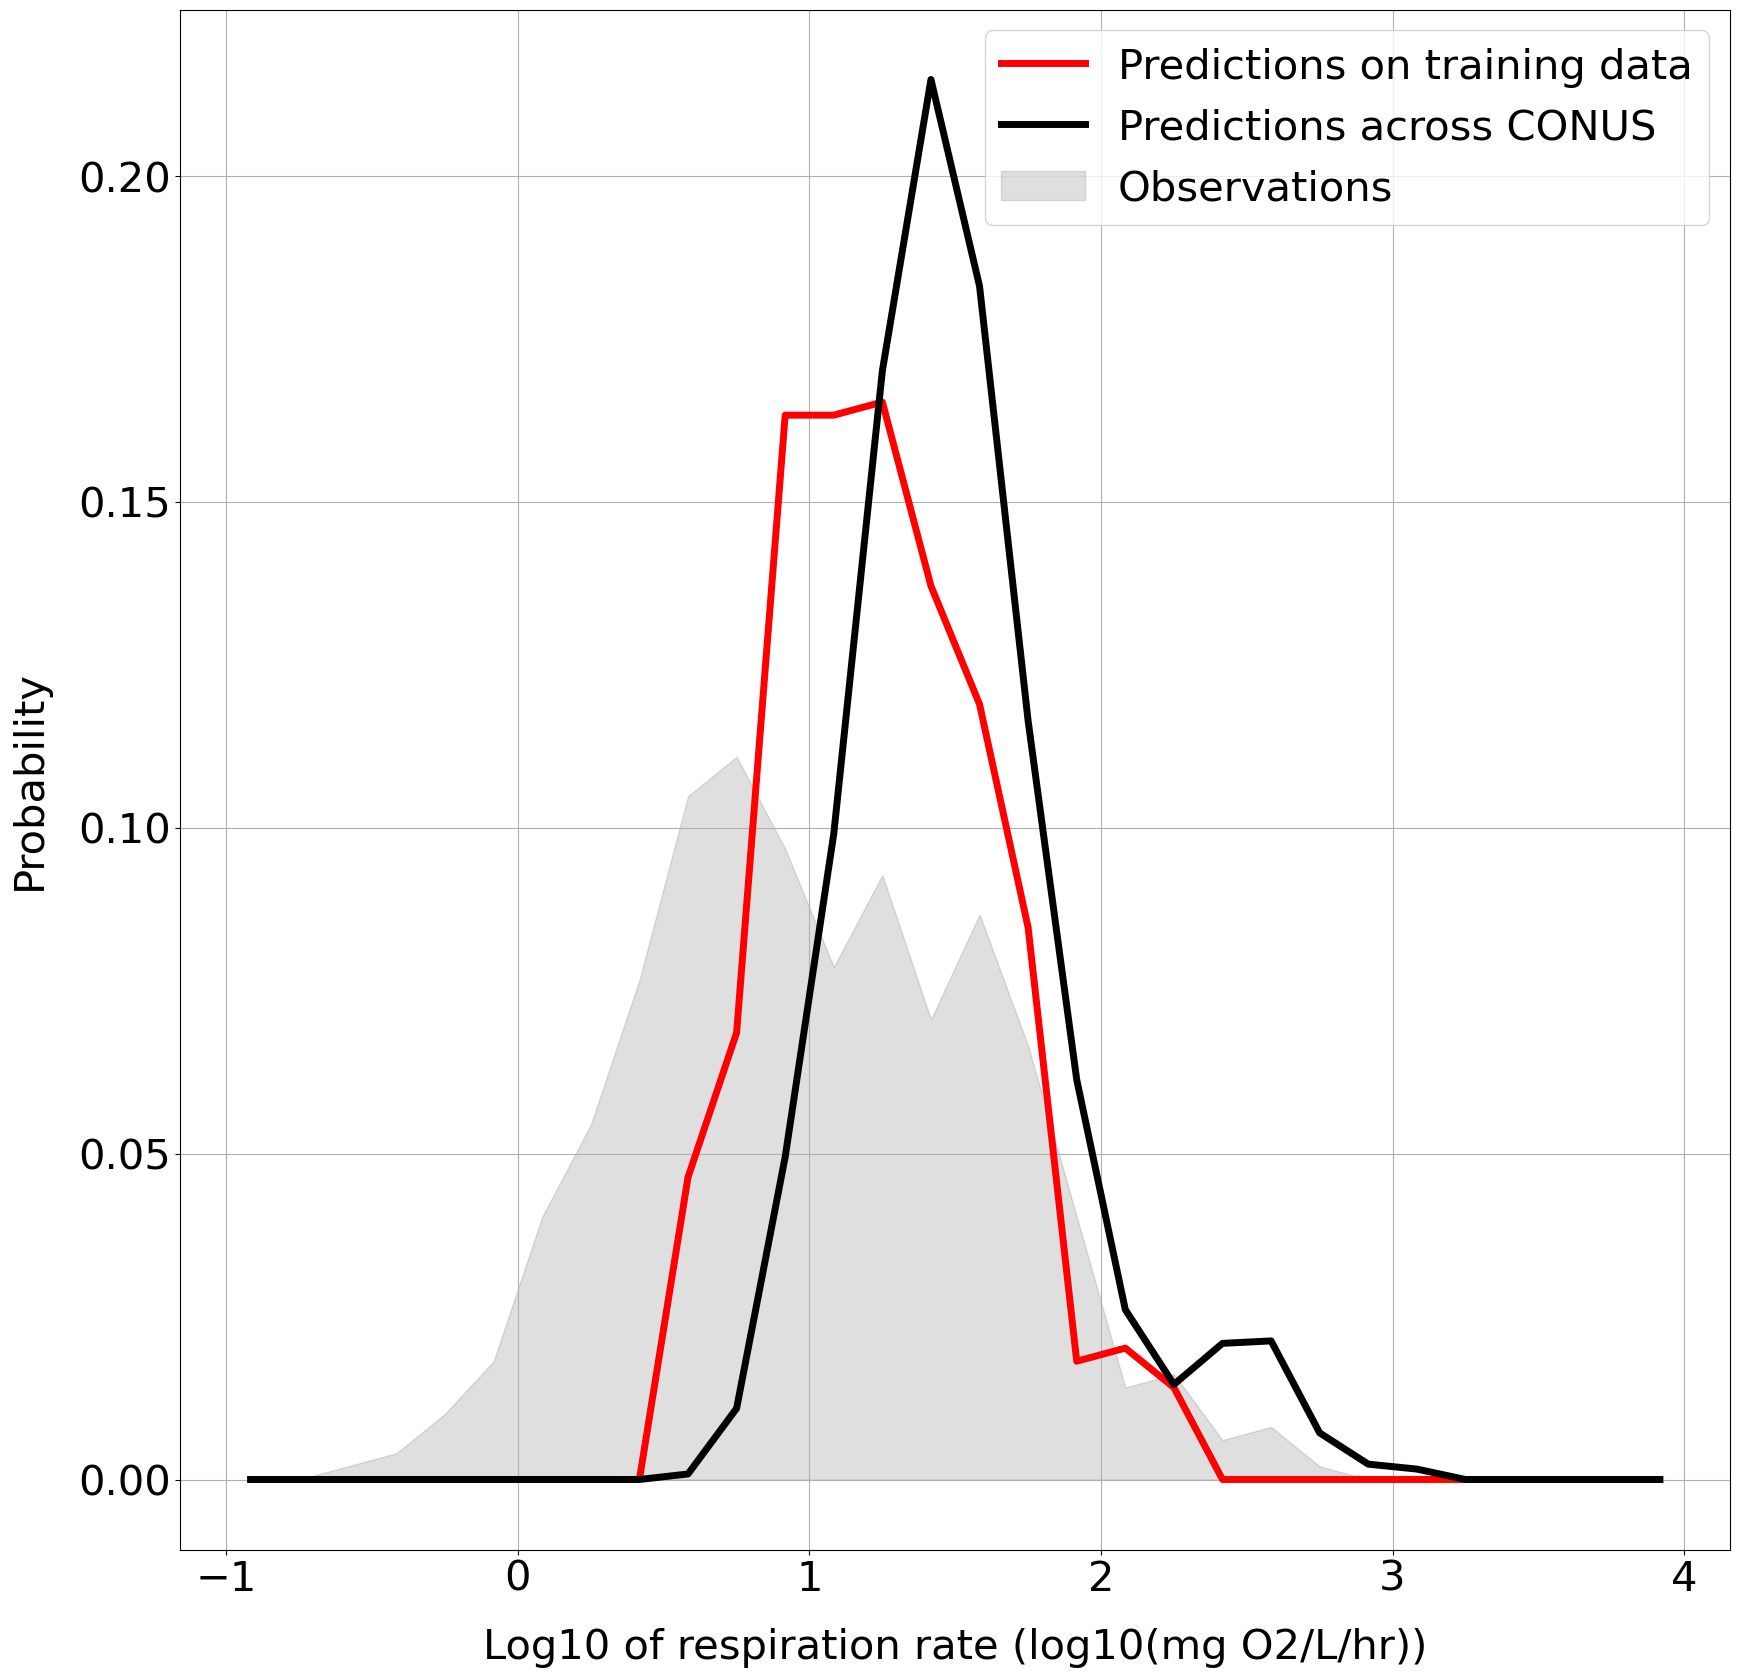

In [3]:
fig, ax0  = plt.subplots(1,1,figsize=(20,20))
line_handles=[]

#======================================================
# Histogram for training set truth reference
#======================================================
counts, bins = np.histogram(np.log10(np.abs(
    observations[
        'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
# Find the center of each bin
# Divide number of counts in each bin by total number of counts => probability
fill_handle = ax0.fill_between(
    (bins[:-1]+bins[1:])/2,0,counts/np.sum(counts), 
    color=('gray'), alpha=0.25)

    
#======================================================
# Histogram for training predictions
#======================================================
# Histogram of the average values predicted by the ensemble 
# of SuperLearners (not the individual SuperLearners' predictions).
counts, bins = np.histogram(np.log10(np.abs(
        training_predictions[
            'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
# Find the center of each bin
# Divide number of counts in each bin by total number of counts => probability
line_handle, = ax0.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), 
    color='r', 
    linewidth=5, alpha=1.0)
    
line_handle.set_label('hello')
line_handles.append(line_handle)

#======================================================
# Histogram for extrapolative predictions
#======================================================
# Histogram of the average values predicted by the ensemble 
# of SuperLearners (not the individual SuperLearners' predictions).
counts, bins = np.histogram(np.log10(np.abs(
        predictions[
            'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
# Find the center of each bin
# Divide number of counts in each bin by total number of counts => probability
line_handle, = ax0.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), 
    color='k', 
    linewidth=5, alpha=1.0)
    
line_handle.set_label('hello')
line_handles.append(line_handle)
    
ax0.grid()
ax0.set_ylabel('Probability', labelpad=20) #, fontsize=18)
ax0.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))', labelpad=20) #, fontsize=18)

line_handles.append(fill_handle)
ax0.legend(line_handles,[
    'Predictions on training data',
    'Predictions across CONUS',
    'Observations'])

plt.subplots_adjust(hspace=0.25)

#plt.savefig('histograms.pdf')